In [3]:
!pip install MTCNN

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 10.5 MB/s eta 0:00:00


In [4]:
import os
import zipfile
import cv2
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm_notebook
from mtcnn.mtcnn import MTCNN
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import InceptionResNetV2 , MobileNetV2 , VGG19
from tensorflow.keras.layers import Input , MaxPooling2D , Conv2D , Dense , Flatten , GlobalAveragePooling2D , Dropout , BatchNormalization

# Importing the LFW dataset

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# To Download the dataset and extract all the files
!pip install -q kaggle

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d jessicali9530/lfw-dataset -p /content/drive/MyDrive/Face_Verification_Model
root = "/content/drive/MyDrive/Face_Verification_Model"

with zipfile.ZipFile(os.path.join(root, 'lfw-dataset.zip'), 'r') as zipper:
    zipper.extractall(root)

# Data Generation and Preprocessing 🔍


In [ ]:
face_cropper = MTCNN()

In [ ]:
people = pd.read_csv("/content/drive/MyDrive/Face_Verification_Model/people.csv")
positives = people[people.images >= 2] # Positive Image pair folders
negatives = people[people.images == 1] # Negative Images

In [ ]:
sample_path = "/content/drive/MyDrive/Face_Verification_Model/lfw-deepfunneled/lfw-deepfunneled/AJ_Lamas/AJ_Lamas_0001.jpg"

def load_image(base_path = None , name = None, id = None, direct_path = None):
    try:
        if direct_path == None:
          img_path = os.path.join(base_path, name, f"{name}_{id:04d}.jpg")
        else:
          img_path = direct_path
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img , cv2.COLOR_BGR2GRAY)
        img = cv2.cvtColor(img , cv2.COLOR_GRAY2BGR)
        results = face_cropper.detect_faces(img)
        x1, y1, width, height = results[0]['box']
        x1, y1 = abs(x1), abs(y1)
        x2, y2 = (x1 + width), (y1 + height)

        img = img[y1:y2, x1:x2]
        img = cv2.resize(img, (100, 100))
        img = img / 255.0
        return img
    except Exception as e:
        print(f"Error loading or preprocessing image: {img_path}, {e}")


def _triplet_generator(positives, negatives, root, train_size):
    triplets = []
    for (index_pos, row_pos), (index_neg, row_neg) in tqdm_notebook(zip(positives[:train_size].iterrows(), negatives[:train_size].iterrows())):
        num_of_imgs = row_pos['images']

        choice = [1, 2]
        if num_of_imgs != 2:
            for i in range(2):
                choice[i] = np.random.randint(1, num_of_imgs + 1)

        # Anchor image
        anchor_img = load_image(root, row_pos['name'], choice[0])

        # Positive image
        positive_img = load_image(root, row_pos['name'], choice[1])

        # Negative image
        negative_img = load_image(root, row_neg['name'], 1)

        if anchor_img is not None and positive_img is not None and negative_img is not None:
          triplets.append([anchor_img, positive_img, negative_img])

    return np.array(triplets)


In [ ]:
base_path = "/content/drive/MyDrive/Face_Verification_Model/lfw-deepfunneled/lfw-deepfunneled"

TRAIN_DATA_SIZE = 1500 # Maximum Number of pairs you can get is 1500

triplets = _triplet_generator(positives , negatives , base_path , TRAIN_DATA_SIZE)

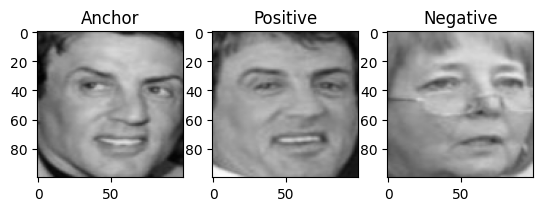

In [13]:
# Visualizing Triplets
def show_triplet(images):
    plt.subplot(1 , 3 , 1)
    plt.title("Anchor")
    plt.imshow(images[0])

    plt.subplot(1 , 3 , 2)
    plt.title("Positive")
    plt.imshow(images[1])

    plt.subplot(1 , 3 , 3)
    plt.title("Negative")
    plt.imshow(images[2])

    plt.savefig("Triplet_data.png")

show_triplet(triplets[280])

In [ ]:
# Necessary Step inorder to avoid wastage of time for loading the data
# Instead save the computed numpy array
np.save('/content/drive/MyDrive/Face_Verification_Model/TripletDataset.npy' , triplets)

In [7]:
# Loading ...
triplets = np.load('/content/drive/MyDrive/Face_Verification_Model/TripletDataset.npy')

# Training Triplet Loss function 📊

In [14]:
# Custom Implementation
def Dense_Block(input_shape):
    model = tf.keras.Sequential([
          Input(shape = input_shape),
          Flatten(),
          Dense(units=1024, activation="relu"),
          Dropout(0.2),
          BatchNormalization(),
          Dense(units=512, activation="relu"),
          Dropout(0.2),
          BatchNormalization(),
          Dense(units=256, activation="relu"),
          Dropout(0.2),
          Dense(units=128)
    ])
    return model

def Siamese_Network(base_model):
    input = Input(shape = (3 , 100 , 100 , 3))
    base_model.trainable = False

    output1 = base_model(input[: , 0])
    output2 = base_model(input[: , 1])
    output3 = base_model(input[: , 2])

    dense_block = Dense_Block(output1.shape[1:])

    output1 = dense_block(output1)
    output2 = dense_block(output2)
    output3 = dense_block(output3)

    output = [output1 , output2 , output3]
    return tf.keras.Model(inputs = input , outputs = output)

In [18]:
@tf.function
def Triplet_loss(y_pred , alpha):
    x1 = y_pred[0][:]
    x2 = y_pred[1][:]
    x3 = y_pred[2][:]

    norm1 = tf.reduce_sum(tf.square(tf.subtract(x1 , x2)) , axis = -1)
    norm2 = tf.reduce_sum(tf.square(tf.subtract(x1 , x3)) , axis = -1)

    loss = tf.reduce_sum(tf.maximum(tf.subtract(norm1 , norm2) + alpha, 0.0))
    return loss

base_model = MobileNetV2(input_shape = (100 , 100 , 3) , weights = 'imagenet' , include_top = False) # Replace with Different Models

In [19]:
Siamese_model = Siamese_Network(base_model)

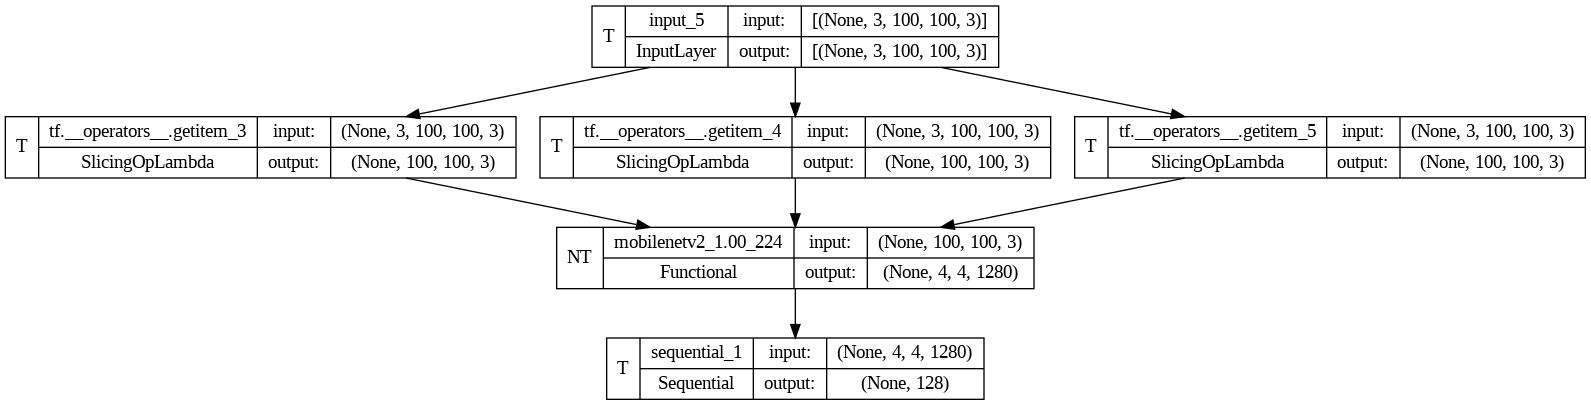

In [22]:
tf.keras.utils.plot_model(Siamese_model , to_file = "Siamese_model.png", show_trainable=True , show_shapes=True)

In [ ]:
Siamese_model.summary()

Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_31 (InputLayer)       [(None, 3, 100, 100, 3)]     0         []                            
                                                                                                  
 tf.__operators__.getitem_4  (None, 100, 100, 3)          0         ['input_31[0][0]']            
 7 (SlicingOpLambda)                                                                              
                                                                                                  
 tf.__operators__.getitem_4  (None, 100, 100, 3)          0         ['input_31[0][0]']            
 8 (SlicingOpLambda)                                                                              
                                                                                           

In [ ]:
def batch_generator(triplets, batch_size):
  idx = np.random.randint(len(triplets), size=batch_size)
  return triplets[idx]

# Custom Training Loop
NUMBER_OF_EPOCHS = 20
BATCH_SIZE = 50
n_steps = len(triplets) // BATCH_SIZE

optimizer = tf.keras.optimizers.Adam()
loss_fn = Triplet_loss
mean_loss = keras.metrics.Mean()

for epoch in range(1, NUMBER_OF_EPOCHS + 1):
  print(f"Epoch {epoch}/{NUMBER_OF_EPOCHS}")

  for step in tqdm_notebook(range(1, n_steps + 1)):
      x_train = batch_generator(triplets, BATCH_SIZE)

      with tf.GradientTape() as tape:
        prediction = Siamese_model(x_train)
        loss = loss_fn(y_pred = prediction , alpha=0.2)

      gradients = tape.gradient(loss, Siamese_model.trainable_variables)
      optimizer.apply_gradients(zip(gradients, Siamese_model.trainable_variables))
      mean_loss.update_state(loss)

  print(f"Epoch {epoch} Loss: {mean_loss.result()}" , end = "\n")
  mean_loss.reset_states()

Epoch 1/20


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 1 Loss: 289.9024353027344
Epoch 2/20


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 2 Loss: 247.69374084472656
Epoch 3/20


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 3 Loss: 203.0453643798828
Epoch 4/20


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 4 Loss: 154.06776428222656
Epoch 5/20


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 5 Loss: 171.08523559570312
Epoch 6/20


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 6 Loss: 87.68141174316406
Epoch 7/20


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 7 Loss: 191.58999633789062
Epoch 8/20


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 8 Loss: 140.55160522460938
Epoch 9/20


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 9 Loss: 301.2049560546875
Epoch 10/20


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 10 Loss: 174.65684509277344
Epoch 11/20


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 11 Loss: 59.22861862182617
Epoch 12/20


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 12 Loss: 36.098297119140625
Epoch 13/20


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 13 Loss: 88.0936508178711
Epoch 14/20


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 14 Loss: 99.01046752929688
Epoch 15/20


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 15 Loss: 85.12237548828125
Epoch 16/20


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 16 Loss: 162.51698303222656
Epoch 17/20


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 17 Loss: 136.7094268798828
Epoch 18/20


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 18 Loss: 107.46011352539062
Epoch 19/20


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 19 Loss: 117.4250259399414
Epoch 20/20


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 20 Loss: 66.99921417236328


In [ ]:
Siamese_model.save('/content/drive/MyDrive/Face_Verification_Model/Siamese_model_MobileNetV2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Face Verification

In [23]:
model_A = tf.keras.models.load_model("/content/drive/MyDrive/Face_Verification_Model/Siamese_model_MobileNetV2.h5")

In [24]:
model_B = tf.keras.models.Sequential(model_A.layers[-2:])
cloned_model = tf.keras.models.clone_model(model_B)
cloned_model.set_weights(model_A.get_weights())

In [25]:
class DistanceLayer(keras.layers.Layer):
  def __init__(self , threshold = 0.3 , **kwargs):
    self.threshold = threshold
    super().__init__(**kwargs)

  def call(self , input):
    encoding_a , encoding_b = input
    # Cosine Similarity
    distance = tf.reduce_sum(tf.multiply(encoding_a , encoding_b) , axis = -1) / (tf.linalg.norm(encoding_a , axis = -1) * tf.linalg.norm(encoding_b , axis = -1))
    return tf.cast(distance >= self.threshold , dtype = 'float32')

In [26]:
input = Input(shape = (2 , 100 , 100 , 3))

encoding1 = cloned_model(input[: , 0])
encoding2 = cloned_model(input[: , 1])

output = DistanceLayer(threshold = 0.9)([encoding1 ,encoding2])
Model = tf.keras.models.Model(inputs = input , outputs = output)

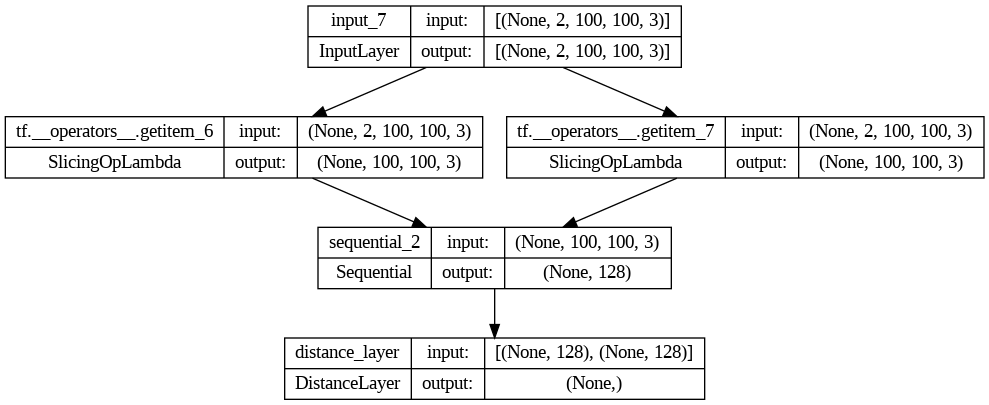

In [27]:
tf.keras.utils.plot_model(Model , to_file = "Face_verfication.png" , show_shapes = True)

# Testing the Model 🧪

In [ ]:
test_pairs = np.load('/content/drive/MyDrive/Face_Verification_Model/TestTriplets.npy')
test_labels = np.load('/content/drive/MyDrive/Face_Verification_Model/TestTripletsLabels.npy')
test_pairs.shape

(199, 2, 100, 100, 3)

In [ ]:
prediction = Model.predict(test_pairs)

7/7 [==============================] - 2s 26ms/step


In [ ]:
print(f"Test Accuracy of the model is {tf.keras.metrics.Accuracy()(prediction , test_labels)}")
confusion_matrix(y_pred = prediction , y_true = test_labels)

Test Accuracy of the model is 0.5778894424438477


array([[18, 83],
       [ 1, 97]])